## Image classification on DL (MobileNetV2). Mask detection. Vol.1

### (Diploma project by student @Pawel_MTW "Skillfactory.ru")

###  Перед нами поставлена задача создать модель, которая будет предсказывать наличие маски на лице человека. Это задача  классификации, нужно научить нейросеть делить картинки  на 2 категории: "С маской на лице" и "Без маски". 
### Для этого мы соберем картинки для обучения и используем глубокое обучение, 1.построим сверточную нейросеть и 2.построим нейросеть на базе MobileNetV2.Обучим, сравним показатели, выберем лучший результат.

## Data importing / Загружаем данные
### Импорт библиотек/модулей. Основные настройки.

In [1]:
!pip install --upgrade pip
!pip install cvlib
!pip install opencv-python
!pip install xmltodict
!pip install mtcnn 
!pip install plot-metric
#!pip install face_recognition
!pip install --upgrade imutils

     |████████████████████████████████| 1.5 MB 4.3 MB/s eta 0:00:01
  Attempting uninstall: pip
    Found existing installation: pip 20.3.1
    Uninstalling pip-20.3.1:
      Successfully uninstalled pip-20.3.1
     |████████████████████████████████| 10.0 MB 4.2 MB/s eta 0:00:01    |███▊                            | 1.2 MB 4.2 MB/s eta 0:00:03     |█████▍                          | 1.7 MB 4.2 MB/s eta 0:00:02
  Created wheel for cvlib: filename=cvlib-0.2.6-py3-none-any.whl size=10044620 sha256=c218c75c21f3d787b2662fccf76c0775977f964750981f805012f70cdf7a3aa6
  Stored in directory: /root/.cache/pip/wheels/9b/96/9b/373c07517ffe0bedbebc0813aec1e62cb2bb1dee91b3694895
  Created wheel for imutils: filename=imutils-0.5.4-py3-none-any.whl size=25858 sha256=028bc359b3e2e87f0141634d8ae36a0063a79e56e23edcbf1f6e2e2b03a15333
  Stored in directory: /root/.cache/pip/wheels/86/d7/0a/4923351ed1cec5d5e24c1eaf8905567b02a0343b24aa873df2
  Created wheel for progressbar: filename=progressbar-2.5-py3-none-any

In [2]:
import cv2
import json
import os
import argparse
import xmltodict
import plot_metric
import pylab as pl
import cvlib as cv
import numpy as np 
import pandas as pd 
import seaborn as sns
import sys, cv2, time
from PIL import Image
import tensorflow as tf
import scikitplot as skplt
from mtcnn.mtcnn import MTCNN
from matplotlib import pyplot
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
from keras.utils import plot_model
from scipy.spatial import distance
from keras.models import Sequential
from warnings import filterwarnings
from keras.models import load_model
from matplotlib.patches import Rectangle
from keras.optimizers import Adam, RMSprop
from sklearn.metrics import roc_auc_score
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from plot_metric.functions import BinaryClassification
from sklearn.metrics import confusion_matrix, accuracy_score
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from keras.layers import Conv2D, MaxPool2D, Dropout, Dense, Flatten
from keras.losses import binary_crossentropy, categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import SpatialDropout2D, BatchNormalization, Input, Activation
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint


DATA_PATH = '../input/'
PATH = "../working/" 
face_model = cv2.CascadeClassifier('../input/haar-cascades-for-face-detection/haarcascade_frontalface_default.xml')


HEIGHT = 120
WEIGHT = 120
batch_size = 32
MIN_DISTANCE = 80

num_classes = 2
labels=["No Mask","Mask"]
mask_label = {0:"No Mask",1:"Mask"}
color_label = {0:(0,0,255),1:(0,255,0),2:(255,0,0),3:(0,0,0),4:(255,255,255)}
dist_label = {0:(0,255,0),1:(255,0,0)}

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

filterwarnings("ignore")

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    pass   # print(dirname)
    #print(os.path.join(dirname, filename))
    
#print(os.listdir(DATA_PATH))

In [3]:
!pip freeze > requirements.txt

### Будем использовать данные из нескольких датасетов, чтобы данных было много.
### Объединим датасеты в группы по предназначению: Train, Test, Validation.

In [4]:
train_dirs = ["/kaggle/input/withwithout-mask/maskdata/maskdata/train",
             "/kaggle/input/withwithout-mask/masks2.0/masks/train",
             "/kaggle/input/face-mask-12k-images-dataset/Face Mask Dataset/Train",
             "/kaggle/input/faces-with-masks"]

test_dirs = ["/kaggle/input/withwithout-mask/maskdata/maskdata/test",
            "/kaggle/input/withwithout-mask/masks2.0/masks/test",
            "/kaggle/input/face-mask-12k-images-dataset/Face Mask Dataset/Test",
            "/kaggle/input/face-mask-detection/dataset"]

validation_dirs = ["/kaggle/input/face-mask-12k-images-dataset/Face Mask Dataset/Validation"]

In [5]:
fullimg = []
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        fullimg.append(os.path.join(dirname, filename))

## Preprocessing / Обработка данных

### Используем ImageDataGenerator для аугментации данных:

#### Аугментация вариант №1

In [6]:
train_data_generator = ImageDataGenerator(rescale=1./255, #финальный 
                                          rotation_range=15, #15 
                                          zoom_range=0.15,
                                          width_shift_range=0.15,
                                          height_shift_range=0.15,
                                          shear_range=0.15, horizontal_flip=True,
                                          fill_mode="nearest")

#train_data_generator = ImageDataGenerator(rescale=1./255, #рабочий
                              #       zoom_range=0.2,
                              #       shear_range=0.2,
                              #       rotation_range=0.2)
            
test_data_generator = ImageDataGenerator(rescale=1./255)

validation_data_generator = ImageDataGenerator(rescale=1./255, #финальный 
                                          rotation_range=15, #15 
                                          zoom_range=0.15,
                                          width_shift_range=0.15,
                                          height_shift_range=0.15,
                                          shear_range=0.15, horizontal_flip=True,
                                          fill_mode="nearest")

#### Аугментация вариант №2 через albumentations.

In [7]:
#!pip install git+https://github.com/mjkvaak/ImageDataAugmentor

In [8]:
#from ImageDataAugmentor.image_data_augmentor import *
#import albumentations

In [9]:
# Аугментация вариант №2 через albumentations. 
"""
AUGMENTATIONS = albumentations.Compose([
    albumentations.HorizontalFlip(p=0.5),
    albumentations.Rotate(limit=45, interpolation=1, border_mode=4, value=None, mask_value=None, always_apply=False, p=0.5),
    albumentations.OneOf([
        albumentations.CenterCrop(height=250, width=200),
        albumentations.CenterCrop(height=200, width=250),
    ],p=0.5),
    albumentations.OneOf([
        albumentations.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3),
        albumentations.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1)
    ],p=0.5),
    albumentations.GaussianBlur(p=0.05),
    albumentations.HueSaturationValue(p=0.5),
    albumentations.RGBShift(p=0.5),
    albumentations.FancyPCA(alpha=0.1, always_apply=False, p=0.5),
    albumentations.Resize(120, 120)
    ])

train_data_generator = ImageDataAugmentor(
        rescale=1./255,
        augment = AUGMENTATIONS,
        #validation_split=VAL_SPLIT,
        )

validation_data_generator = ImageDataAugmentor(
        rescale=1./255,
        augment = AUGMENTATIONS,
        #validation_split=VAL_SPLIT,
        )

test_data_generator = ImageDataAugmentor(rescale=1./255)
"""

'\nAUGMENTATIONS = albumentations.Compose([\n    albumentations.HorizontalFlip(p=0.5),\n    albumentations.Rotate(limit=45, interpolation=1, border_mode=4, value=None, mask_value=None, always_apply=False, p=0.5),\n    albumentations.OneOf([\n        albumentations.CenterCrop(height=250, width=200),\n        albumentations.CenterCrop(height=200, width=250),\n    ],p=0.5),\n    albumentations.OneOf([\n        albumentations.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3),\n        albumentations.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1)\n    ],p=0.5),\n    albumentations.GaussianBlur(p=0.05),\n    albumentations.HueSaturationValue(p=0.5),\n    albumentations.RGBShift(p=0.5),\n    albumentations.FancyPCA(alpha=0.1, always_apply=False, p=0.5),\n    albumentations.Resize(120, 120)\n    ])\n\ntrain_data_generator = ImageDataAugmentor(\n        rescale=1./255,\n        augment = AUGMENTATIONS,\n        #validation_split=VAL_SPLIT,\n        )\n\nvali

## Генерация данных. Завернем наши данные в генератор:

In [10]:
print("Data image Train")
train_generator1 = train_data_generator.flow_from_directory(
        train_dirs[0],
        target_size=(HEIGHT,WEIGHT),
        batch_size=77,
        interpolation="nearest",
        class_mode='binary',
        classes=["without_mask","with_mask"])
train_generator2 = train_data_generator.flow_from_directory(
        train_dirs[1],
        target_size=(HEIGHT,WEIGHT),
        batch_size=46,
        interpolation="nearest",
        class_mode='binary',
        classes=["0","1"])
train_generator3 = train_data_generator.flow_from_directory(
        train_dirs[2],
        target_size=(HEIGHT,WEIGHT),
        batch_size=80,
        interpolation="nearest",
        class_mode='binary',
        classes=["WithoutMask","WithMask"])
train_generator4 = train_data_generator.flow_from_directory(
        train_dirs[3],
        target_size=(HEIGHT,WEIGHT),
        batch_size=163,
        interpolation="nearest",
        class_mode='binary',
        classes=["_","faces_with_mask"])


print("\nData image Test")
test_generator1 = test_data_generator.flow_from_directory(
        test_dirs[0],
        target_size=(HEIGHT,WEIGHT),
        batch_size=66,
        interpolation="nearest",
        class_mode='binary',
        classes=["without_mask","with_mask"])
test_generator2 = test_data_generator.flow_from_directory(
        test_dirs[1],
        target_size=(HEIGHT,WEIGHT),
        batch_size=11,
        interpolation="nearest",
        class_mode='binary',
        classes=["0","1"])
test_generator3 = test_data_generator.flow_from_directory(
        test_dirs[2],
        target_size=(HEIGHT,WEIGHT),
        batch_size=62,
        interpolation="nearest",
        class_mode='binary',
        classes=["WithoutMask","WithMask"])
test_generator4 = test_data_generator.flow_from_directory(
        test_dirs[3],
        target_size=(HEIGHT,WEIGHT),
        batch_size=55,
        interpolation="nearest",
        class_mode='binary',
        classes=["without_mask","with_mask"])

print("\nData image Validation")
validation_generator1 = validation_data_generator.flow_from_directory(
        validation_dirs[0],
        target_size=(HEIGHT,WEIGHT),
        batch_size=80,
        interpolation="nearest",
        class_mode='binary',
        classes=["WithoutMask","WithMask"])
withWithoutMask = {"0":"Without Mask","1":"With Mask"}

Data image Train
Found 616 images belonging to 2 classes.
Found 92 images belonging to 2 classes.
Found 10000 images belonging to 2 classes.
Found 1630 images belonging to 2 classes.

Data image Test
Found 198 images belonging to 2 classes.
Found 33 images belonging to 2 classes.
Found 992 images belonging to 2 classes.
Found 440 images belonging to 2 classes.

Data image Validation
Found 800 images belonging to 2 classes.


In [11]:
def genToTuple(gen):
    templist = []
    templist2 = []
    for i in range(gen.__len__()):
        tempnext = gen.next()
        templist.append(tempnext[0])
        templist2.append(tempnext[1])
    x=np.concatenate(templist)
    y=np.concatenate(templist2)
    return (x,y)

def combine_tuple(*tuples):
    x=np.concatenate([tuples[i][0] for i in range(len(tuples))])
    y=np.concatenate([tuples[i][1] for i in range(len(tuples))])
    return (x,y.astype(int))   

train_generator1_t = genToTuple(train_generator1)
train_generator2_t = genToTuple(train_generator2)
train_generator3_t = genToTuple(train_generator3)
train_generator4_t = genToTuple(train_generator4)

test_generator1_t = genToTuple(test_generator1)
test_generator2_t = genToTuple(test_generator2)
test_generator3_t = genToTuple(test_generator3)
test_generator4_t = genToTuple(test_generator4)

x_train,y_train = combine_tuple(train_generator1_t,train_generator2_t,train_generator3_t,train_generator4_t)

x_test,y_test = combine_tuple(test_generator1_t,test_generator2_t,test_generator3_t,test_generator4_t)

x_val,y_val = genToTuple(validation_generator1)

In [12]:
print(x_train.shape,y_train.shape)
print(x_test.shape,y_test.shape)
print(x_val.shape,y_val.shape)

(12338, 120, 120, 3) (12338,)
(1663, 120, 120, 3) (1663,)
(800, 120, 120, 3) (800,)


### Посмотрим на равномерность распределения картинок по категориям.
#### Распределение в целом равномерное, небольшой перевес  в обучающей выборке в категории "With mask", но поскольку мы будем использовать предобученную сеть MobileNet V2, то это не повлияет на конечный результат.

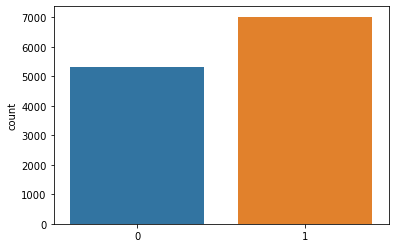

In [13]:
# смотрим распределение картинок по категориям в TRAIN:
sns.countplot(y_train)

In [14]:
# смотрим кол-во картинок по категориям в TRAIN:
category = pd.DataFrame(y_train)  
category.value_counts()

1    7023
0    5315
dtype: int64

In [15]:
# смотрим кол-во картинок по категориям в TRAIN в %:
#category = pd.DataFrame(y_train)  
category.value_counts(normalize=True)


1    0.569217
0    0.430783
dtype: float64

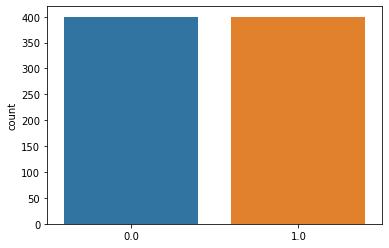

In [16]:
# смотрим распределение картинок по категориям в VALIDATION:
sns.countplot(y_val)

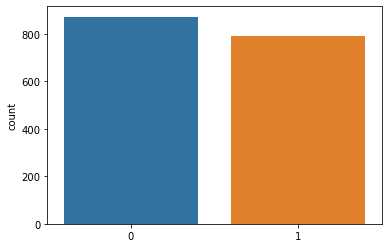

In [17]:
# смотрим распределение картинок по категориям в TEST:
sns.countplot(y_test) 

## Build Model / Построение модели.

### Вариант #1. Строим сверточную нейронную сеть CNN для классификации лиц по фото по категориям:

In [18]:
# Вариант 1 построения сети: Результат accuracy_test: 0.945

def build_model():
        model = Sequential()
        
        model.add(Input(shape=(HEIGHT,WEIGHT,3,)))

        model.add(Conv2D(filters=16,kernel_size=(2,2),padding="same"))
        model.add(Activation("relu"))
        model.add(SpatialDropout2D(0.25)) #0.45
        
        model.add(MaxPool2D(pool_size=(4,4)))

        model.add(Conv2D(filters=32,kernel_size=(2,2),padding="same"))
        model.add(Activation("relu"))
        model.add(SpatialDropout2D(0.25)) # 0.45
        
        model.add(MaxPool2D(pool_size=(4,4),strides=(4,4)))
               
        model.add(Flatten())
        
        model.add(Dense(2048)) # 1024
        model.add(Activation("relu"))
        model.add(Dropout(0.25)) #0.45
        
        model.add(Dense(1024)) # 256
        model.add(Activation("relu"))
        model.add(Dropout(0.2)) #0.4
        
        
        model.add(Dense(1))
        model.add(Activation("sigmoid"))
        
        optimizer = Adam(lr=0.001)
        model.compile(optimizer = optimizer ,metrics=["accuracy"], loss = binary_crossentropy)
        
        return model
    
#model = build_model() 

### Вариант #2 построения сети на базе предообученной сети MobileNet V2 (alpha=1.4)

На момент выполнения проекта сеть MobileNet V2 все ещё является оптимальным выбором, если брать во внимание размер сети, точность предсказаний и время работы, хотя уже появилась MobileNet V3. 
Итоговый результат обученной модели аccuracy: 0.9855%

In [19]:
mobilenet = MobileNetV2(alpha=1.4,weights='imagenet',include_top=False,input_shape=(HEIGHT,WEIGHT,3,))
for layer in mobilenet.layers:
    layer.trainable = False
model = Sequential()
model.add(mobilenet)
#model.add(MaxPool2D(pool_size=(4,4),strides=(4,4)))
model.add(Flatten())
model.add(Dense(256)) #512
model.add(Activation("relu"))
model.add(Dropout(0.55)) #0.25       
#model.add(Dense(128))
#model.add(Activation("relu")) #model.add(Dropout(0.4)) #0.2              
model.add(Dense(1))
model.add(Activation("sigmoid")) 
model.compile(optimizer="adam",loss=binary_crossentropy, metrics ="accuracy") 
model.summary()

17833984/17831080 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.40_224 (Functi (None, 4, 4, 1792)        4363712   
_________________________________________________________________
flatten (Flatten)            (None, 28672)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               7340288   
_________________________________________________________________
activation (Activation)      (None, 256)               0         
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
_________________________________________________________

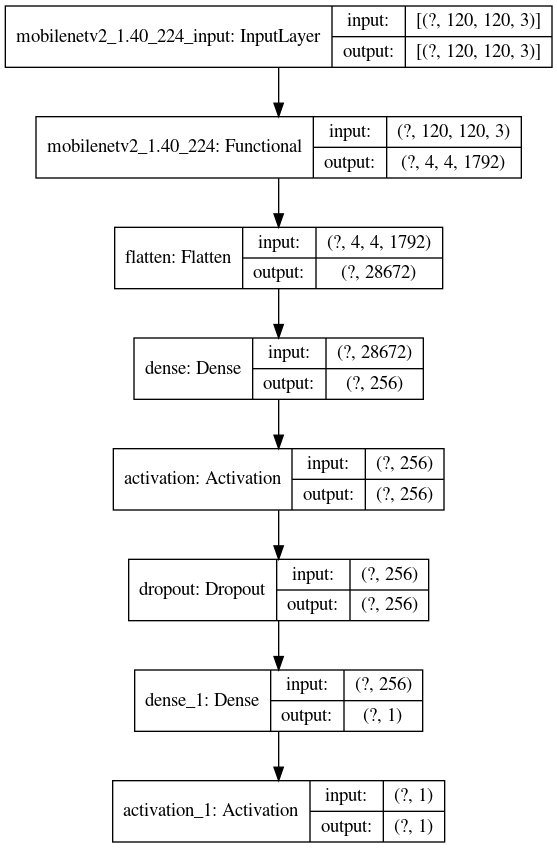

In [20]:
# можно также вывести итоговую схему нейросети в виде красивой картинки: 
plot_model(model,show_shapes=True,show_layer_names=True)

## Train Model / Обучение модели.

### Поскольку мы используем классификацию, то берем метрику Loss и Accuracy для оценки работы сети.

In [21]:
#  Используем ReduceLROnPlateau
# ReduceLROnPlateau - уменьшаемый LR: когда результат уже не меняется, LR  уменьшается, и так до min предела указанного:
reducer = ReduceLROnPlateau(monitor='loss',patience=3,factor=0.75,min_lr=0.000000001,verbose=1) #monitor='val_acc' loss
checkpoint = ModelCheckpoint("facemask.h5",monitor="val_accuracy",save_best_only=True,verbose=1)
stopSign = EarlyStopping(monitor = "loss",patience=10,min_delta=0.000000000001,mode="min")

epochs = 100 #120
batch_size = 32 
steps_per_epoch = x_train.shape[0] // batch_size
history = model.fit(x_train, y_train,
                    epochs = epochs, 
                    validation_data = (x_val,y_val),
                    verbose = 1,
                    batch_size=batch_size,
                    steps_per_epoch = steps_per_epoch,
                    callbacks=[stopSign,checkpoint
                               ,reducer
                              ])

Epoch 1/100
382/385 [============================>.] - ETA: 0s - loss: 0.2511 - accuracy: 0.9800
Epoch 00001: val_accuracy improved from -inf to 0.99625, saving model to facemask.h5
385/385 [==============================] - 9s 23ms/step - loss: 0.2495 - accuracy: 0.9799 - val_loss: 0.0129 - val_accuracy: 0.9962
Epoch 2/100
383/385 [============================>.] - ETA: 0s - loss: 0.0291 - accuracy: 0.9901
Epoch 00002: val_accuracy did not improve from 0.99625
385/385 [==============================] - 7s 19ms/step - loss: 0.0290 - accuracy: 0.9902 - val_loss: 0.0137 - val_accuracy: 0.9950
Epoch 3/100
384/385 [============================>.] - ETA: 0s - loss: 0.0245 - accuracy: 0.9933
Epoch 00003: val_accuracy improved from 0.99625 to 0.99875, saving model to facemask.h5
385/385 [==============================] - 8s 21ms/step - loss: 0.0245 - accuracy: 0.9933 - val_loss: 0.0132 - val_accuracy: 0.9987
Epoch 4/100
384/385 [============================>.] - ETA: 0s - loss: 0.0347 - accur

Epoch 29/100
384/385 [============================>.] - ETA: 0s - loss: 0.0010 - accuracy: 0.9994
Epoch 00029: val_accuracy did not improve from 0.99875
385/385 [==============================] - 7s 19ms/step - loss: 0.0010 - accuracy: 0.9994 - val_loss: 0.0099 - val_accuracy: 0.9987
Epoch 30/100
383/385 [============================>.] - ETA: 0s - loss: 0.0025 - accuracy: 0.9993
Epoch 00030: val_accuracy did not improve from 0.99875
385/385 [==============================] - 7s 18ms/step - loss: 0.0025 - accuracy: 0.9993 - val_loss: 0.0114 - val_accuracy: 0.9987
Epoch 31/100
384/385 [============================>.] - ETA: 0s - loss: 0.0020 - accuracy: 0.9993
Epoch 00031: val_accuracy did not improve from 0.99875
385/385 [==============================] - 7s 18ms/step - loss: 0.0020 - accuracy: 0.9993 - val_loss: 0.0065 - val_accuracy: 0.9987
Epoch 32/100
385/385 [==============================] - ETA: 0s - loss: 0.0027 - accuracy: 0.9993
Epoch 00032: val_accuracy did not improve from 

## Training and Validation Visualizations / визуализация процесса обучения

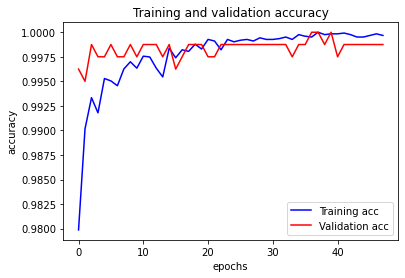

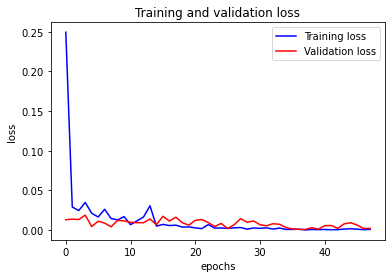

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('accuracy')
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')
 
plt.show()

##  Prediction / Предсказание

### Делаем предсказания на тестовых данных. Выводим матрицу ошибок.

### Результаты получились отличные: крайне небольшое кол-во ложно положительных и малое кол-во ложно отрицательных предсказаний.

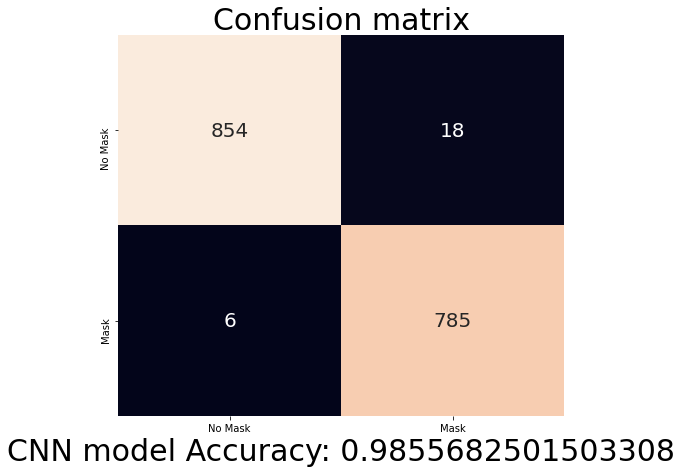

In [23]:
y_pred_classes = model.predict_classes(x_test)
y_pred = model.predict(x_test)

plt.subplots(figsize=(8,7))
sns.heatmap(confusion_matrix(y_test,y_pred_classes),xticklabels=labels,
                                       yticklabels=labels, annot=True,fmt="1.0f",cbar=False,annot_kws={"size": 20})
plt.title("Confusion matrix",fontsize=30)
plt.xlabel(f"CNN model Accuracy: {accuracy_score(y_test,y_pred_classes)}",fontsize=30)
plt.show()

### Printing Classification report/ выводим Classification отчет:

In [24]:
print(classification_report(y_test, y_pred_classes, target_names = labels))

              precision    recall  f1-score   support

     No Mask       0.99      0.98      0.99       872
        Mask       0.98      0.99      0.98       791

    accuracy                           0.99      1663
   macro avg       0.99      0.99      0.99      1663
weighted avg       0.99      0.99      0.99      1663



### Вывод: precision и recall показатели очень высокие (почти избегаем ошибок I и II рода).

В нашей проблематике хотелось бы в первую очередь снизить FN (ошибку II рода) - это когда "без маски", но модель говорит что "в маске".

### Отчет по метрикам:

In [25]:
# считаем Score модели:
test_loss, test_acc = model.evaluate(x_test, y_test, steps=32)
print('The final test accuracy: ',test_acc)
print('The final test loss: ',test_loss)

32/32 [==============================] - 1s 27ms/step - loss: 0.2548 - accuracy: 0.9856
The final test accuracy:  0.9855682253837585
The final test loss:  0.25484010577201843


### Результаты метрики Accuracy (best = 0.9855) получились отличными.

### Cчитаем Auc-roс, строим кривую.

In [26]:
y_pred_proba = model.predict_proba(x_test)

In [27]:
# calculate the fpr and tpr for all thresholds of the classification
fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred_proba)
roc_auc = metrics.auc(fpr, tpr)
roc_auc

0.9950170496062354

In [28]:
def plot_roc_cur(fper, tper):  
    plt.plot(fper, tper, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

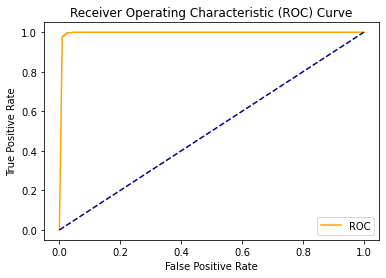

In [29]:
plot_roc_cur(fpr, tpr)

### Roc_curve кривую, матрицу ошибок и отчет по метрикам можно вывести вот такой единой красочной таблицей:

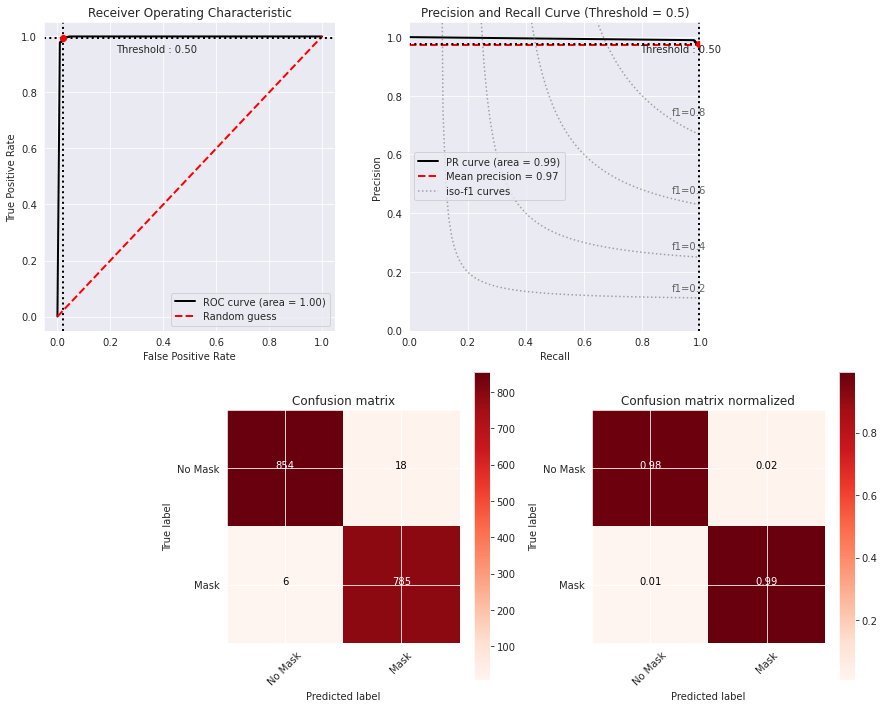

                   ________________________
                  |  Classification Report |
                   ‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾
              precision    recall  f1-score   support

     No Mask       0.99      0.98      0.99       872
        Mask       0.98      0.99      0.98       791

    accuracy                           0.99      1663
   macro avg       0.99      0.99      0.99      1663
weighted avg       0.99      0.99      0.99      1663



In [30]:
# Визуализируем plot_metric
bc = BinaryClassification(y_test,y_pred, labels) 
# Figures
plt.figure(figsize=(15,10))
plt.subplot2grid(shape=(2,6), loc=(0,0), colspan=2)
bc.plot_roc_curve()
plt.subplot2grid((2,6), (0,2), colspan=2)
bc.plot_precision_recall_curve()
#plt.subplot2grid((2,6), (0,4), colspan=2)
#bc.plot_class_distribution()
plt.subplot2grid((2,6), (1,1), colspan=2)
bc.plot_confusion_matrix()
plt.subplot2grid((2,6), (1,3), colspan=2)
bc.plot_confusion_matrix(normalize=True)
plt.show()
bc.print_report()

## Сохраним модель в файл:

In [31]:
model.save('model_mask.hdf5')

### Выведем примеры предсказаний применительно к картинкам из датасетов: 
### 1.Подборка: правильно предсказанные случаи

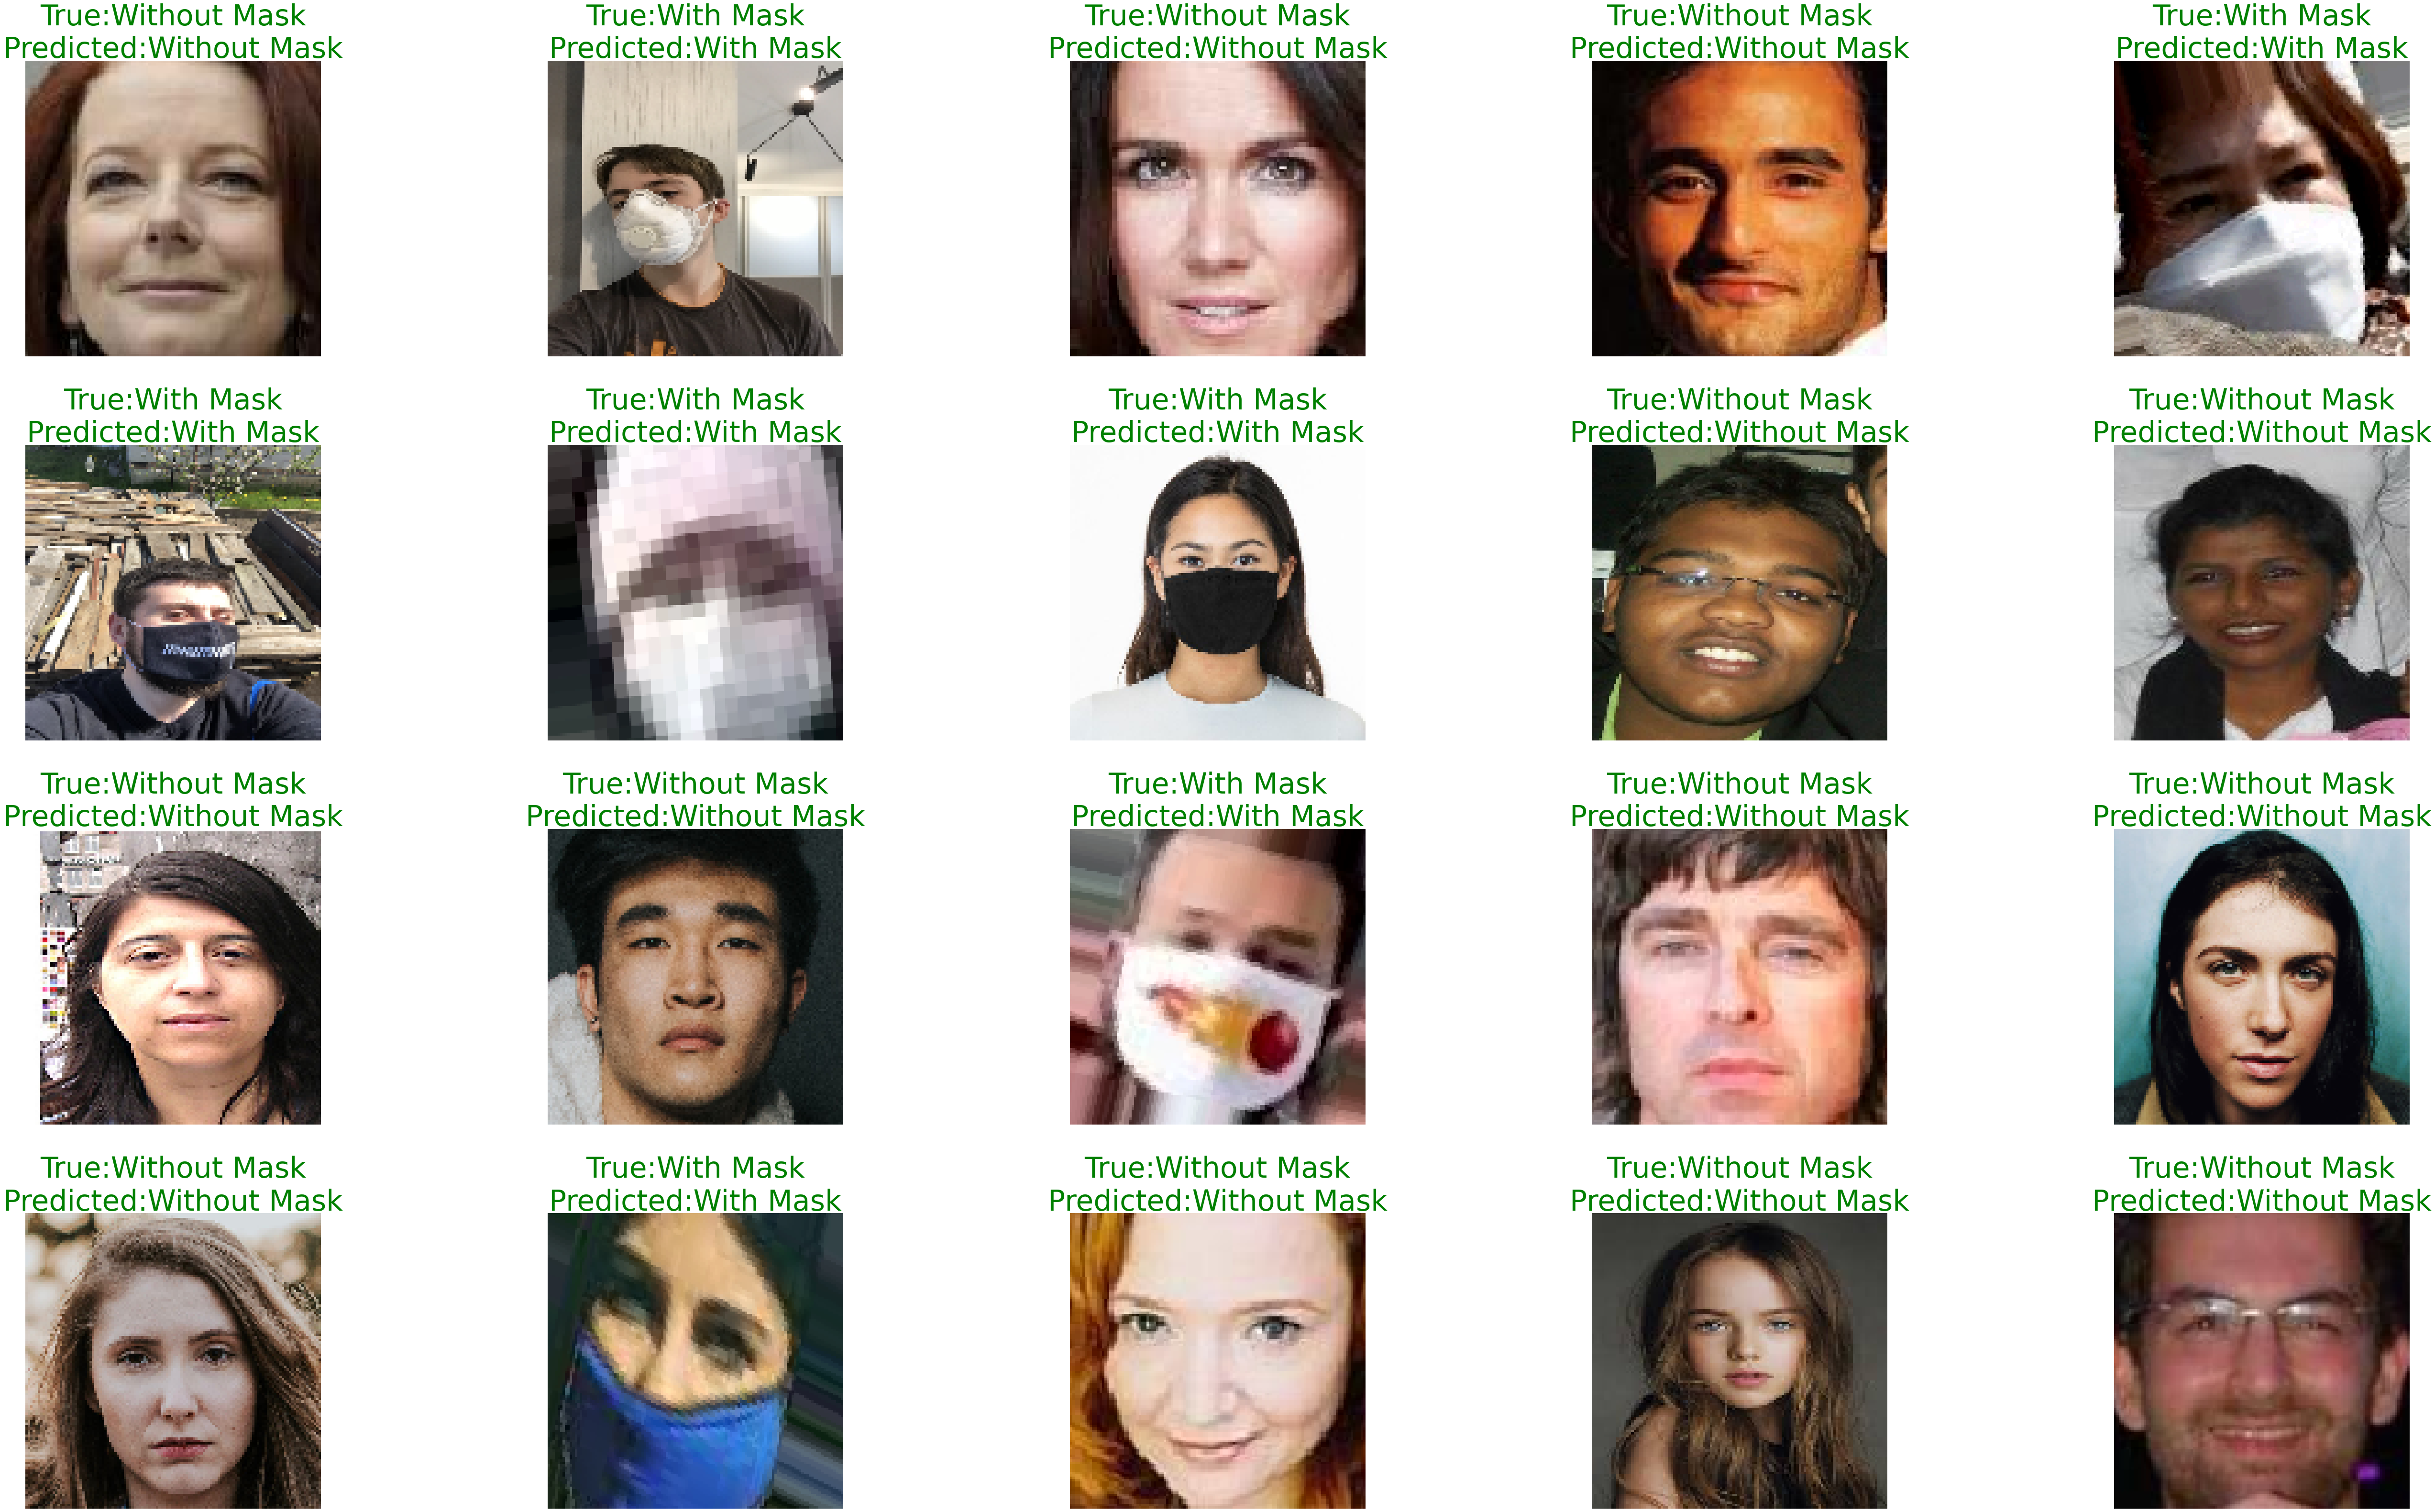

In [32]:
plt.figure(figsize=(100,100))
tempc = np.random.choice(x_test[y_test == y_pred_classes.ravel()].shape[0],20,replace=False)
d = 0
for i in tempc:
    plt.subplot(7, 5, d+1)
    d += 1
    tempc = np.random.randint(x_test[y_test == y_pred_classes.ravel()].shape[0])
    plt.imshow(x_test[y_test == y_pred_classes.ravel()][tempc])
    plt.title(f"True:{withWithoutMask[str(y_test[y_test == y_pred_classes.ravel()][tempc])]}\nPredicted:{withWithoutMask[str(y_pred_classes.ravel()[y_test == y_pred_classes.ravel()][tempc])]}",
              fontsize=60,color='g')
    plt.axis("off")
plt.subplots_adjust(wspace=-0.1, hspace=0.3)
plt.show()

### 2.Подборка: неправильно предсказаные случаи.

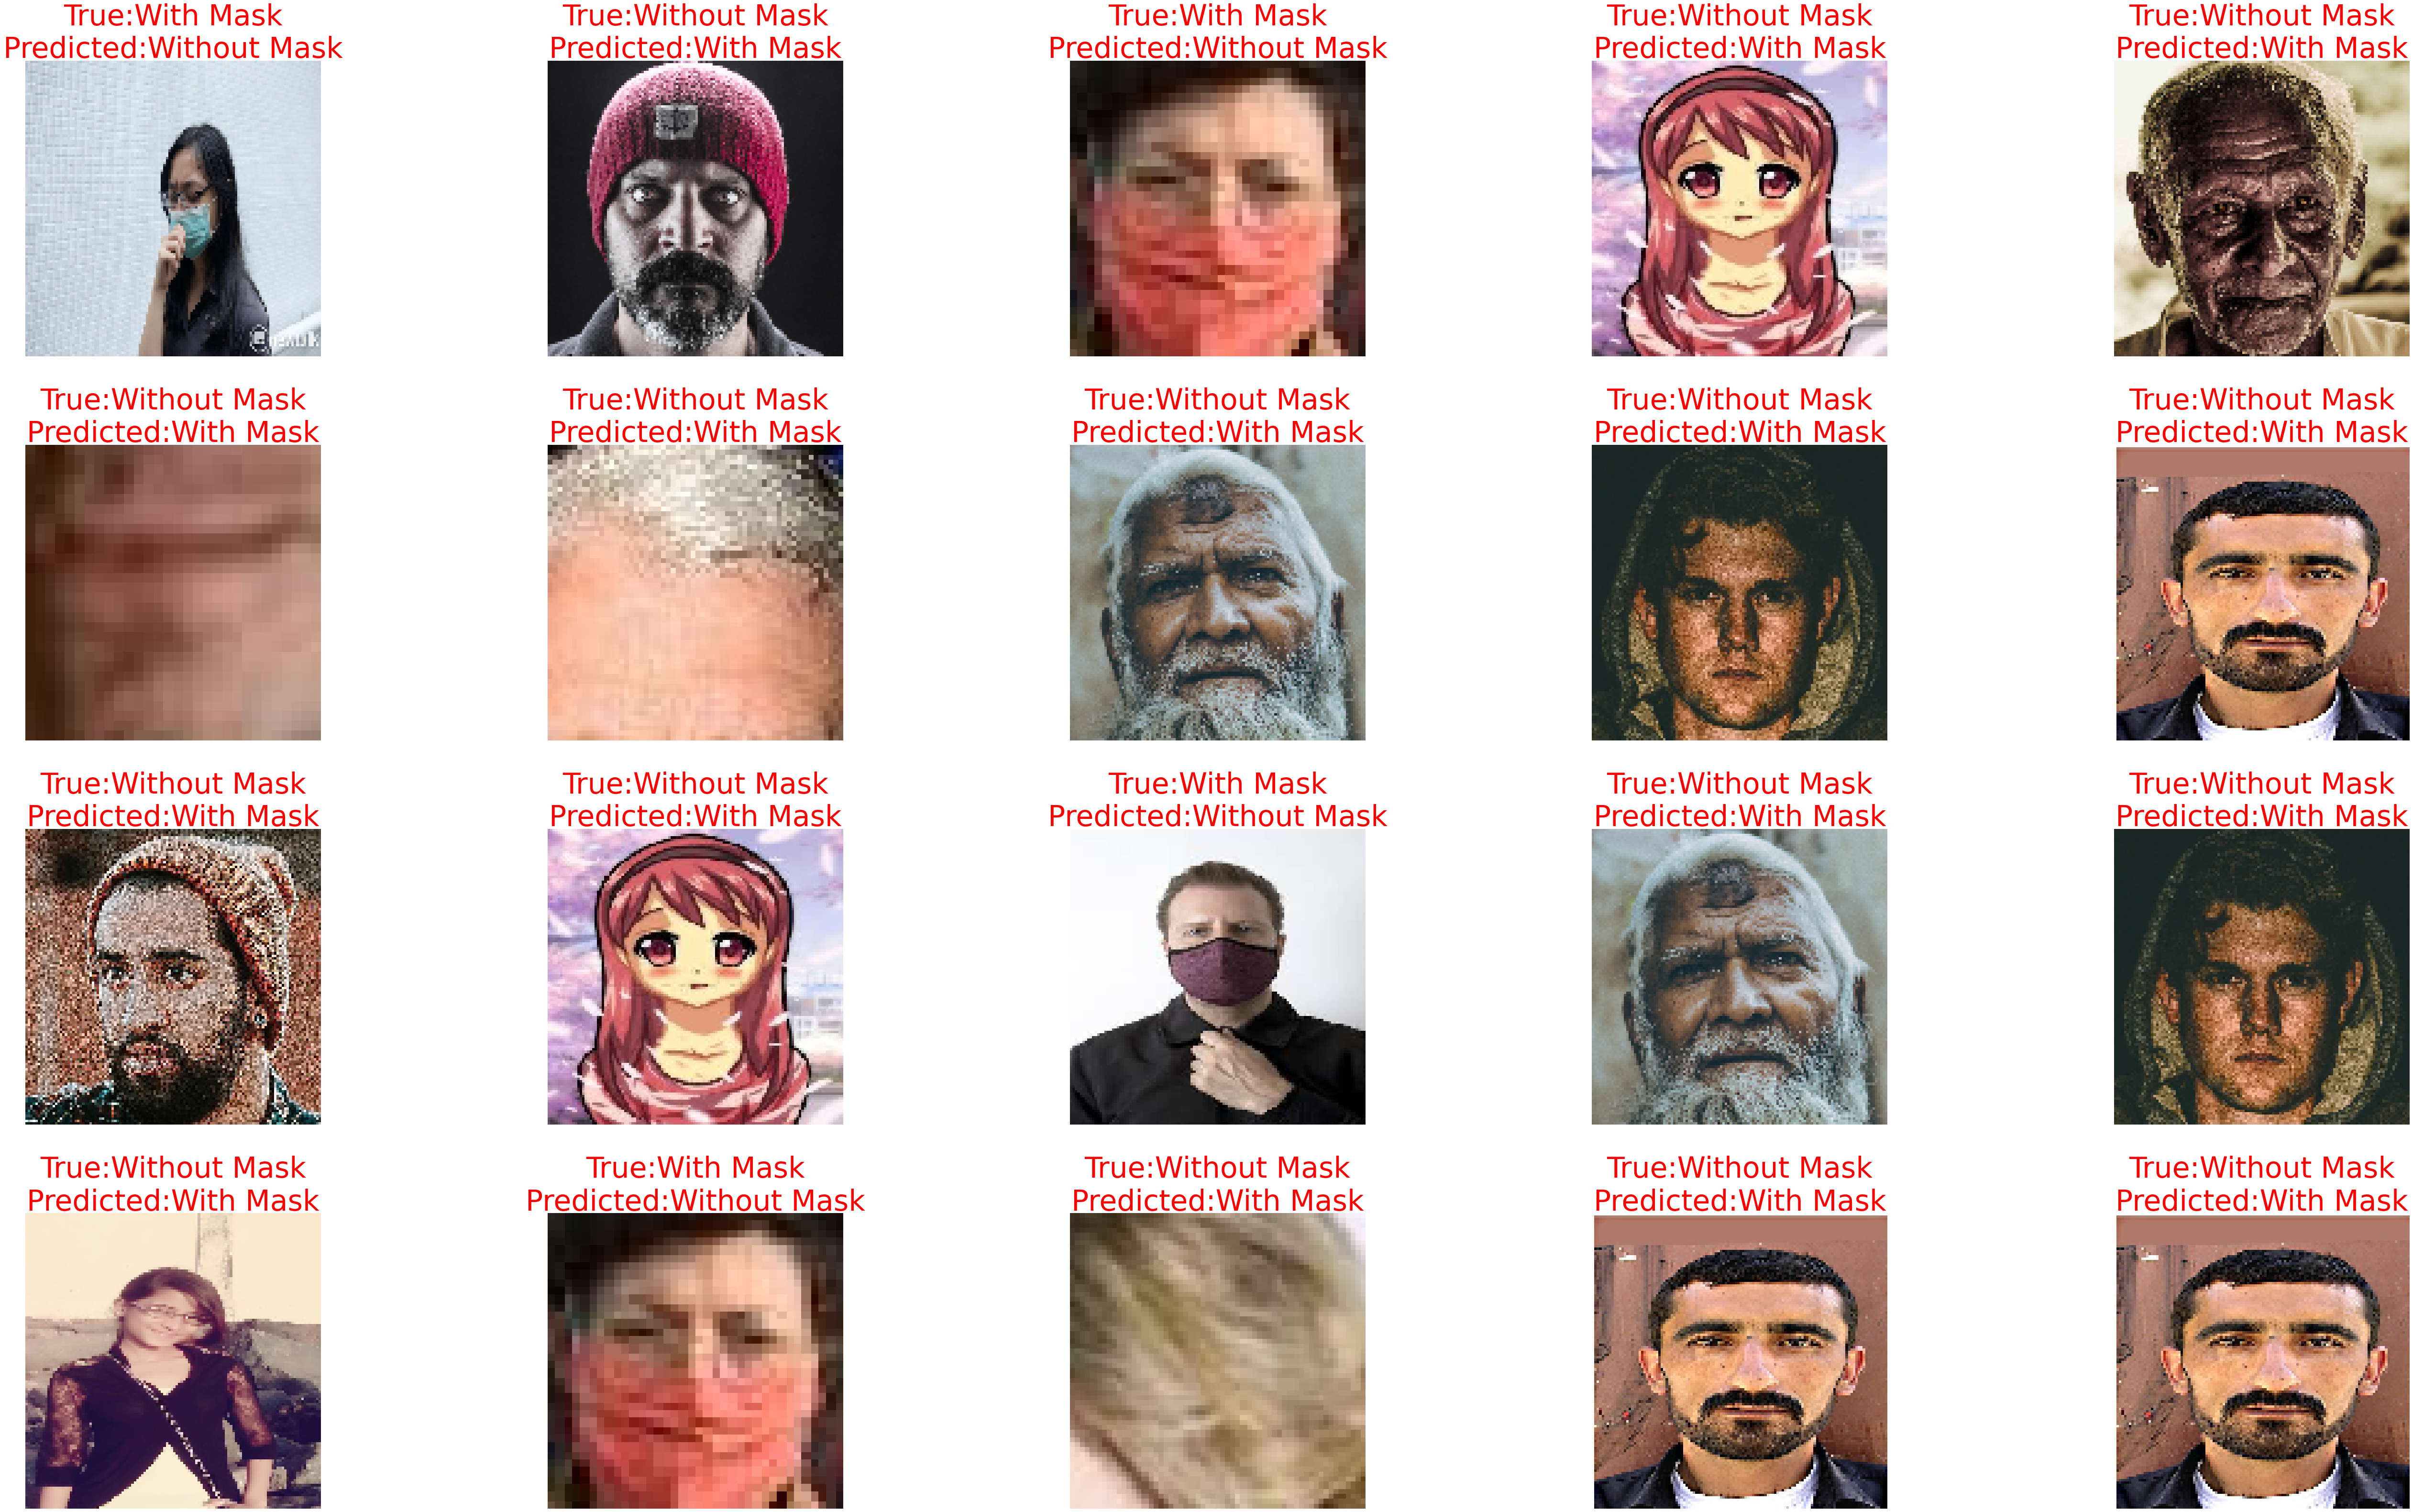

In [33]:
plt.figure(figsize=(100,100))
tempc = np.random.choice(x_test[y_test != y_pred_classes.ravel()].shape[0],20,replace=False)
d = 0
for i in tempc:
    plt.subplot(7, 5, d+1)
    d += 1
    tempc = np.random.randint(x_test[y_test != y_pred_classes.ravel()].shape[0])
    plt.imshow(x_test[y_test != y_pred_classes.ravel()][tempc])
    plt.title(f"True:{withWithoutMask [str(y_test[y_test != y_pred_classes.ravel()][tempc])]}\nPredicted:{withWithoutMask[str(y_pred_classes.ravel()[y_test != y_pred_classes.ravel()][tempc])]}", fontsize=60, color='r')
    plt.axis("off")
plt.subplots_adjust(wspace=-0.1, hspace=0.3)
plt.show()

## Итоги: 
### В данном ноутбуке мы сделали следующее: мы разработали модели согласно поставленной задаче, а именно, сверточную модель на основе нейронных сетей,и модель на базе предобученной нейросети MobilNetV2 large (которая показала лучший результат). Наша модель предсказывает отношения лица к одному из 2 классов ("С Маской"/"Без маски"). Обучили модель. Также мы проанализировали показатели модели. Сохранили модель для дальнейшего использования. Учитывая все сказанное (исходя из полученных показателей), модель должна работать очень хорошо.



### В Vol.2 ноутбуке мы займемся практическим использованием нашей обученной модели для фото, в Vol.3 - мы реализуем максимальные возможности нашей модели на видеопотоке, создадим прототип дальнейшего использования в виде системы контроля Video real-time.